### Import Packages

In [1]:
import pandas as pd
import logging 
import os
import time
import requests 
import tiktoken
import ray
import numpy as np
import json
import pickle
import openai

from math import ceil
from numba import jit
from sklearn.metrics.pairwise import cosine_similarity

# In order for ray to work, make sure you uninstall pydantic and reinstall this: pip install "pydantic<2"
from class_data.data import Data
from utils.system import *

# Set OPENAI KEY
os.environ["OPENAI_API_KEY"] = json.load(open(get_config() / 'api.json'))['openai_api_key']

import warnings
warnings.filterwarnings('ignore')

### CC

In [4]:
# Daily Multiple CC Metadata
mdata = Data(folder_path=get_data() / 'cc_multiple', file_pattern='*_mdata.pq')
mdata = mdata.concat_files()
mdata['date'] = pd.to_datetime(mdata['startDate'], format='%d-%b-%y %I:%M%p %Z')
mdata['date'] = mdata['date'].dt.date
mdata['date'] = pd.to_datetime(mdata['date'])
print(mdata.shape)

Loading Data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 439/439 [00:01<00:00, 403.90it/s]


(438179, 8)


In [5]:
# Daily Multiple CC Articles
contents = Data(folder_path=get_data() / 'cc_multiple', file_pattern='*_contents.pq')
contents = contents.concat_files()
print(contents.shape)

Loading Data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 439/439 [00:30<00:00, 14.36it/s]


(28022815, 4)


In [6]:
# Filter mdata for sp500
mdata_sp500 = mdata.loc[mdata.companyTicker.isin(sp500)]
len(mdata_sp500.companyTicker.unique())

660

In [7]:
# Join contents and mdata
mdata_sp500 = mdata_sp500.set_index('fid')
contents = contents.set_index('fid')
contents_all = mdata_sp500.join(contents)

In [8]:
# Set index
contents_all = contents_all.reset_index().set_index(['fid', 'date'])
contents_all.shape

(5861667, 9)

In [9]:
# Filter for conference calls
cc_substrings = ['corporate conference call', 'earnings call', 'earnings conference call', 'conference call']
contents_all['cc_or_not'] = contents_all['Headline'].str.lower().str.contains('|'.join(cc_substrings))
cc = contents_all.loc[contents_all['cc_or_not'] == True]
cc.shape

(4449978, 10)

In [10]:
# Get word count
@jit
def fast_word_count(texts):
    counts = np.zeros(len(texts), dtype=np.int32)
    for i, text in enumerate(texts):
        if isinstance(text, str):  
            counts[i] = len(text.split())
        else:
            counts[i] = 0  
    return counts

cc['word_count'] = fast_word_count(cc['body'].values)

In [12]:
# Filter for text with >= 100 words
cc = cc.loc[cc.word_count >= 100]
cc.shape

(929712, 11)

In [13]:
# Filter for only QA
cc = cc.loc[cc.content_type == 'QA']
cc.shape

(747323, 11)

word count mean: 183.45420922412399
word count std: 95.80383703189669
word count max: 7472


<Axes: >

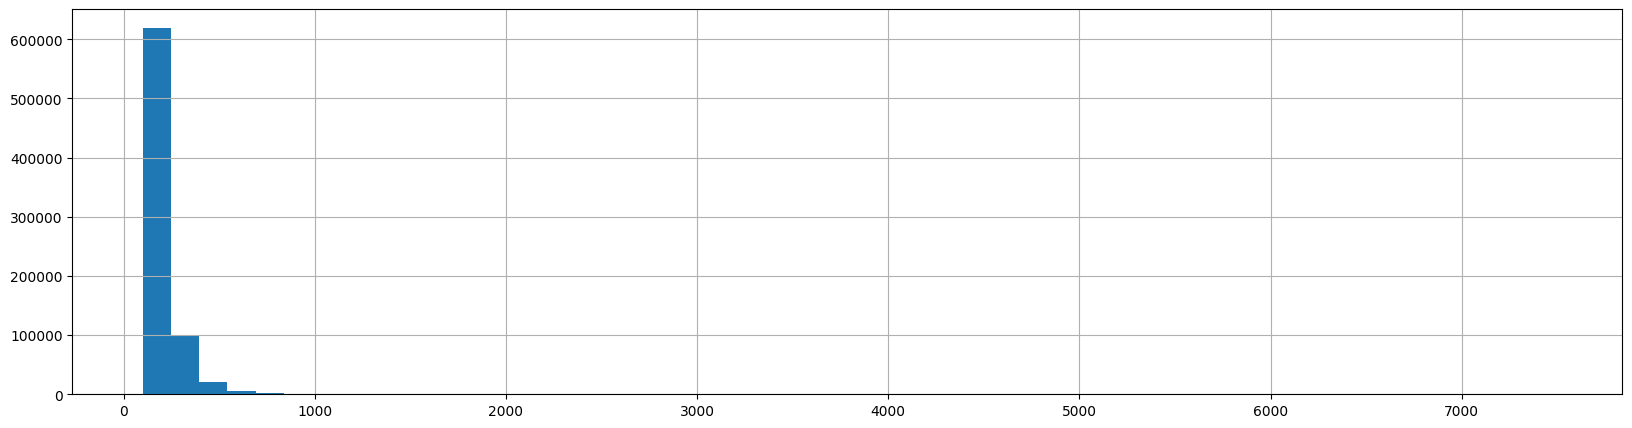

In [16]:
# Display Metrics
print("word count mean:", cc.word_count.mean())
print("word count std:", cc.word_count.std())
print("word count max:", cc.word_count.max())
cc.word_count.hist(bins=50, figsize=(20,5))

In [14]:
# Rename column 'body' to 'body_txt' (same as WSJ)
cc = cc.rename(columns={'body':'body_txt'})

In [18]:
cc.head(1)

,,Headline,eventTitle,city,companyName,companyTicker,startDate,name,body_txt,content_type,cc_or_not,word_count
fid,date,,,,,,,,,,,
1000000,2005-07-28,Edited Transcript of MTW earnings conference c...,Q2 2005 Manitowoc Earnings Conference Call,Manitowoc,Manitowoc Company Inc,MTW,28-Jul-05 3:00pm GMT,"Carl Laurino, Manitowoc - SVP, CFO [3]","No, I certainly don't think there's anything t...",QA,True,133


In [19]:
# Export Data
chunks = np.array_split(cc, 50)
for i, df in enumerate(chunks, 1):
    print(i)
    df.to_parquet(get_format_data() / 'art' / f'cc_art_{i}.parquet.brotli', compression='brotli')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


### Parallelized: Get embeddings (per article)

In [20]:
@ray.remote
def get_embedding_article(article_text, model):
    try:
        embedding = openai.embeddings.create(input=[article_text.replace("\n", " ")], model=model).data[0].embedding
        return embedding
    except Exception as e:
        logging.error(f"An error occurred: {str(e)}")
        return None

def process_articles_in_batches(output_folder, file_prefix, df, column_name, model, batch_size, delay_per_batch):
    num_batches = np.ceil(len(df) / batch_size)
    times = []
    
    for i in range(int(num_batches)):
        start_time = time.time()
        
        # Check if the batch has already been processed
        # save_path = get_format_data() / 'openai' / f'cc_emb_textemb3small_{i}.parquet.brotli'
        save_path = output_folder / f'{file_prefix}_{i}.parquet.brotli'
        if save_path.exists():
            print(f"Skipping batch {i + 1}/{int(num_batches)} (already processed)")
            continue

        # Get batch
        start_index = i * batch_size
        end_index = min(start_index + batch_size, len(df))
        batch = df[column_name][start_index:end_index]
        
        # Start asynchronous tasks for the batch
        futures = [get_embedding_article.remote(text, model) for text in batch]
        embeddings = ray.get(futures)

        # Save Batch
        print(f"Saving progress to {save_path}")
        all_indices = df.index[start_index:end_index]
        temp_df = pd.DataFrame({'ada_embedding': embeddings}, index=all_indices)
        temp_df.to_parquet(save_path, compression='brotli')
        print("Progress saved")

        # Delay between batches if specified
        if delay_per_batch > 0:
            time.sleep(delay_per_batch)
        
        # Time taken for the batch
        end_time = time.time()
        batch_time = end_time - start_time
        times.append(batch_time)
        
        # Calculate and print the time taken for the batch
        print(f"Batch {i + 1}/{int(num_batches)} processed in {batch_time:.2f} seconds")
        
        # Calculate and print estimated time to finish
        avg_time_per_batch = np.mean(times)
        batches_left = int(num_batches) - (i + 1)
        estimated_time_left = avg_time_per_batch * batches_left
        hours, rem = divmod(estimated_time_left, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"Estimated time to finish: {int(hours)}h {int(minutes)}m {seconds:.2f}s")
        
    return None

In [25]:
# Read in data
cc_multiple = Data(folder_path=get_format_data() / 'art', file_pattern='cc_art_*')
cc_multiple = cc_multiple.concat_files()
print(cc_multiple.shape)

Loading Data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.54it/s]


(747323, 11)


In [26]:
# Parameters
output_folder = get_format_data() / 'openai'
file_prefix = 'cc_emb_textemb3small'
model_name = 'text-embedding-3-small'
batch_size = 1000
delay_per_batch = 0

In [27]:
# Process articles in batches
ray.init(num_cpus=16, ignore_reinit_error=True)

start_time = time.time()
process_articles_in_batches(output_folder=output_folder, file_prefix=file_prefix, df=cc_multiple[['body_txt']], column_name='body_txt', model=model_name, batch_size=batch_size, delay_per_batch=delay_per_batch)
elapsed_time = time.time() - start_time
print(f"Total time to get all embeddings: {round(elapsed_time)} seconds")

# Shutdown Ray
ray.shutdown()

2024-04-21 00:27:53,719	INFO worker.py:1673 -- Started a local Ray instance.


Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\format\openai\cc_emb_textemb3small_0.parquet.brotli
Progress saved
Batch 1/748 processed in 20.02 seconds
Estimated time to finish: 4h 9m 18.14s
Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\format\openai\cc_emb_textemb3small_1.parquet.brotli
Progress saved
Batch 2/748 processed in 15.73 seconds
Estimated time to finish: 3h 42m 16.58s
Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\format\openai\cc_emb_textemb3small_2.parquet.brotli
Progress saved
Batch 3/748 processed in 16.31 seconds
Estimated time to finish: 3h 35m 28.49s
Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\format\openai\cc_emb_textemb3small_3.parquet.brotli
Progress saved
Batch 4/748 processed in 17.28 seconds
Estimated time to finish: 3h 34m 57.33s
Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\format\openai\cc_emb_textemb3small_4.parquet.br

(get_embedding_article pid=32428) ERROR:root:An error occurred: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens, however you requested 8456 tokens (8456 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\format\openai\cc_emb_textemb3small_247.parquet.brotli
Progress saved
Batch 248/748 processed in 15.50 seconds
Estimated time to finish: 2h 20m 53.80s
Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\format\openai\cc_emb_textemb3small_248.parquet.brotli
Progress saved
Batch 249/748 processed in 15.52 seconds
Estimated time to finish: 2h 20m 34.10s
Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\format\openai\cc_emb_textemb3small_249.parquet.brotli
Progress saved
Batch 250/748 processed in 16.45 seconds
Estimated time to finish: 2h 20m 16.30s
Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\format\openai\cc_emb_textemb3small_250.parquet.brotli
Progress saved
Batch 251/748 processed in 17.04 seconds
Estimated time to finish: 2h 19m 59.68s
Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\format\openai\cc_emb_textemb3s

(get_embedding_article pid=7776) ERROR:root:An error occurred: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens, however you requested 9228 tokens (9228 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\format\openai\cc_emb_textemb3small_633.parquet.brotli
Progress saved
Batch 634/748 processed in 14.70 seconds
Estimated time to finish: 0h 30m 48.37s
Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\format\openai\cc_emb_textemb3small_634.parquet.brotli
Progress saved
Batch 635/748 processed in 14.03 seconds
Estimated time to finish: 0h 30m 31.76s
Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\format\openai\cc_emb_textemb3small_635.parquet.brotli
Progress saved
Batch 636/748 processed in 14.52 seconds
Estimated time to finish: 0h 30m 15.26s
Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\format\openai\cc_emb_textemb3small_636.parquet.brotli
Progress saved
Batch 637/748 processed in 18.06 seconds
Estimated time to finish: 0h 29m 59.37s
Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\format\openai\cc_emb_textemb3s